In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import os
import pandas as pd
import numpy as np
import plotnine as gg
import esm
import GPUtil

from data import utils as du
from omegaconf import OmegaConf
from data import se3_diffuser
from model import score_network
from experiments import train_se3_diffusion
import tree
import torch
import matplotlib.pyplot as plt


In [3]:
available_gpus = ''.join(
    [str(x) for x in GPUtil.getAvailable(
        order='memory', limit = 8)])
device = f'cuda:{available_gpus[0]}'

In [4]:
weight_path = '/data/rsg/chemistry/jyim/projects/flow-matching/se3_diffusion/weights/scope_weights.pth'
weights_pkl = du.read_pkl(
    weight_path, use_torch=True, map_location=device)

In [5]:
ckpt_cfg = weights_pkl['conf']
base_path = '/data/rsg/chemistry/jyim/projects/flow-matching/se3_diffusion/config/base.yaml'
base_cfg = OmegaConf.load(base_path)
model_cfg = OmegaConf.merge(base_cfg.model, ckpt_cfg.model)
exp_cfg = OmegaConf.merge(base_cfg, ckpt_cfg)

In [6]:
exp = train_se3_diffusion.Experiment(conf=exp_cfg)

In [7]:
# Load model
model = exp.model

# Remove module prefix if it exists.
model_weights = weights_pkl['model']
model_weights = {
    k.replace('module.', ''):v for k,v in model_weights.items()}
model.load_state_dict(model_weights)
model = model.to(device)
_ = model.eval()

In [8]:
train_loader, valid_loader, train_sampler, valid_sampler = exp.create_dataset()

In [20]:
train_iter = iter(train_loader)

all_t = []
all_trans_loss = []
for _ in range(10):
    train_batch = next(train_iter)
    train_batch['rots_vf'] = torch.ones(1)
    train_batch = tree.map_structure(lambda x: x.to(device), train_batch)
    with torch.no_grad():
        losses = exp.loss_fn(train_batch)
    batch_t = train_batch['t']
    trans_loss = losses[1]['batch_trans_loss']
    all_t.append(du.move_to_np(batch_t))
    all_trans_loss.append(du.move_to_np(trans_loss))

In [21]:
flat_t = np.concatenate(all_t)
flat_batch_trans_loss = np.concatenate(all_trans_loss)

In [22]:
all_trans_loss[0].shape

(40,)

Text(0.5, 1.0, "FrameDiff: RMSD between model\\'s $x_0$ output and ground truth")

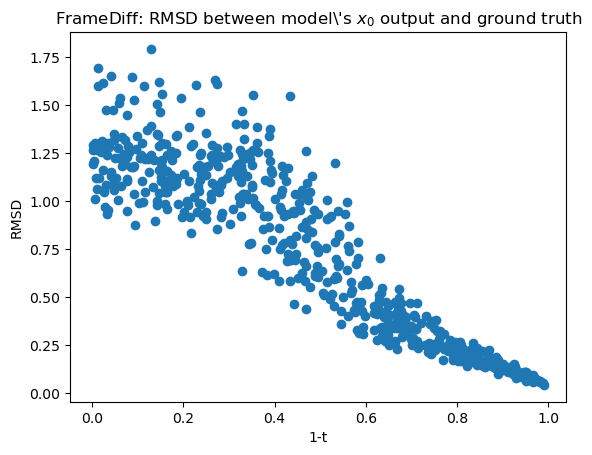

In [27]:
# for i in range(len(all_t)):
plt.scatter(1 - flat_t, np.sqrt(flat_batch_trans_loss))
plt.xlabel('1-t')
plt.ylabel('RMSD')
plt.title(r'FrameDiff: RMSD between model\'s $x_0$ output and ground truth')

In [14]:
all_batch_trans_loss.shape

(589,)

In [28]:
sigma_min = 0.1
sigma_max = 1.5
def sigma(t):
    return np.log(t*np.exp(sigma_max) + (1-t)*np.exp(sigma_min)) 

# Flow VP

In [77]:
beta_min = 0.1
beta_max = 20.0
num_t = 1000
ts = np.linspace(1e-3, 1.0, num_t)

def alpha_t(t):
    return np.exp(-0.5*(t*beta_min + 0.5*t**2*(beta_max - beta_min)))

def alpha_t_prime(t):
    return -0.5*(beta_min + t*(beta_max - beta_min))*alpha_t(t)

def mu_t(x_0, t):
    return alpha_t(t) * x_1

def sigma_t(t):
    return np.sqrt(1 - alpha_t(t)**2)

def p_t(x_0, t):
    return np.random.normal(
        loc=mu_t(x_0, t),
        scale=sigma_t(t)
    )

def vf_t(x, x_0, t):
    alpha_ratio = alpha_t_prime(t) / (1 - alpha_t(t)**2)
    return alpha_ratio * (alpha_t(t) * x - x_0)

In [65]:
num_samples = 100
x_0 = np.ones(num_samples)
x_ts = []
vf_ts = []
for t in ts:
    x_t = p_t(x_0, t)
    vf = vf_t(x_t, x_1, t)
    x_ts.append(x_t)
    vf_ts.append(vf)
x_ts = np.stack(x_ts)
vf_ts = np.stack(vf_ts)

In [73]:
x_1 = p_t(x_0, 1.0)
all_xs = [x_1]
for t in ts[::-1]:
    curr_x = all_xs[-1]
    next_x = curr_x + vf_t(curr_x, x_0, t) * (1 / num_t)
    all_xs.append(next_x)

In [75]:
all_xs = np.stack(all_xs)[:num_t]

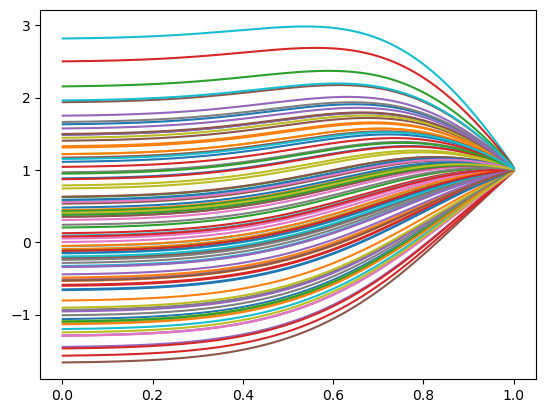

In [76]:
for i in range(num_samples):
    plt.plot(ts, all_xs[:, i])

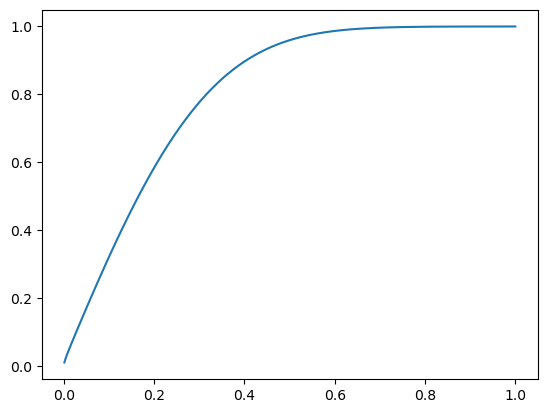

In [80]:
plt.plot(ts, sigma_t(ts))

In [87]:
from scipy.spatial.transform import Rotation
from data import flow_so3_utils

In [92]:
num_samples = 100
rotmats_0 = torch.eye(3, dtype=float)[None].repeat(num_samples, 1, 1)
rotmats_1 = torch.tensor(Rotation.random(num_samples).as_matrix(), dtype=float)

In [100]:
rotmats_ts = []
for t in ts:
    rotmats_t = flow_so3_utils.geodesic_t(1 - sigma_t(t), rotmats_0, rotmats_1)
    rotmats_ts.append(rotmats_t)
rotvecs_ts = flow_so3_utils.rotmat_to_rotvec(torch.stack(rotmats_ts))
rotvecs_ts = du.move_to_np(rotvecs_ts)

In [101]:
rotmag_ts = np.linalg.norm(rotvecs_ts, axis=-1)

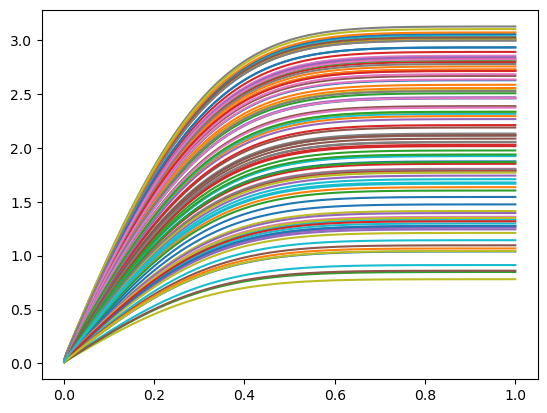

In [102]:
for i in range(num_samples):
    plt.plot(ts, rotmag_ts[:, i])

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
beta_min = 0.1
beta_max = 20.0
num_t = 1000
ts = np.linspace(1e-3, 1.0, num_t)

def alpha_t(t):
    return np.exp(-0.5*(t*beta_min + 0.5*t**2*(beta_max - beta_min)))

def alpha_t_prime(t):
    return -0.5*(beta_min + t*(beta_max - beta_min))*alpha_t(t)

def mu_t(x_0, t):
    return alpha_t(t) * x_1

def sigma_t(t):
    return np.sqrt(1-alpha_t(t)**2)

Text(0.5, 1.0, 't mapping')

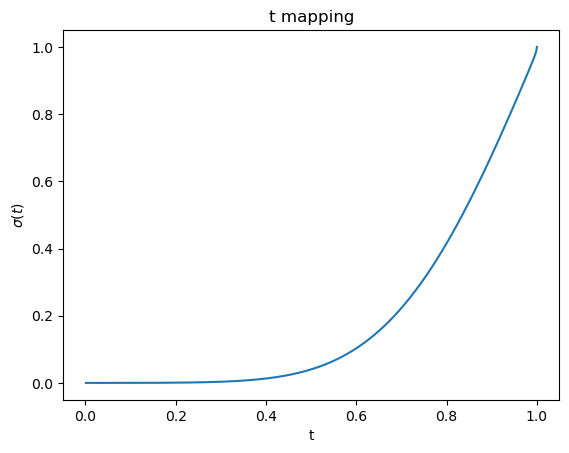

In [8]:
plt.plot(ts, 1-sigma_t(1-ts))
plt.xlabel('t')
plt.ylabel(r'$\sigma(t)$')
plt.title('t mapping')
# plt.plot(ts, 1-sigma_t(ts))

# SE(3) flow logarithmic schedule

In [104]:
beta_min = 0.1
beta_max = 20.0
num_t = 1000
num_samples = 100
ts = np.linspace(1e-3, 1.0, num_t)

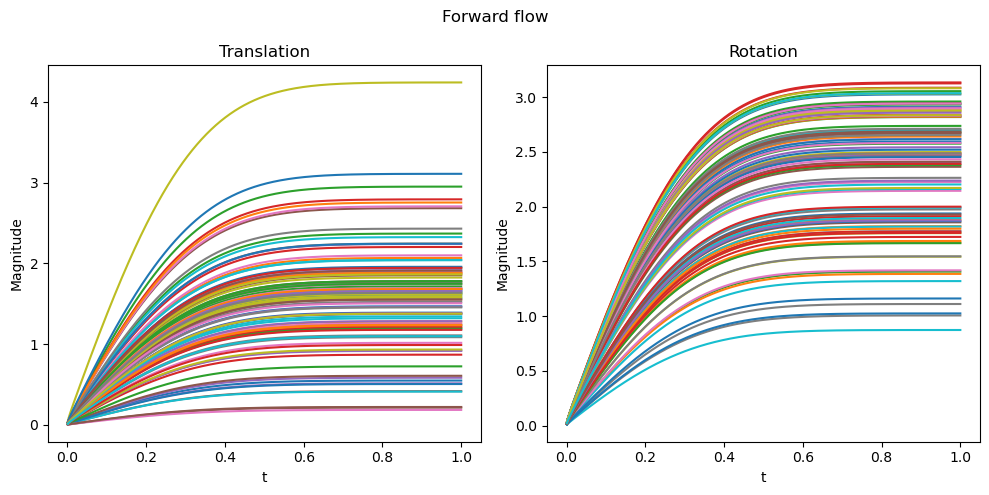

In [177]:
# Forward flow
trans_0 = torch.zeros(num_samples, 3)
rotmats_0 = torch.eye(3, dtype=float)[None].repeat(num_samples, 1, 1)

trans_nm_1 = torch.randn(*trans_0.shape)
rotmats_1 = torch.tensor(Rotation.random(num_samples).as_matrix(), dtype=float)
rotvecs_1 = flow_so3_utils.rotmat_to_rotvec(rotmats_1)

sigma_ts = sigma_t(ts)

all_rotvecs = []
all_trans = []
for t in ts:
    rotmats_t = flow_so3_utils.geodesic_t(1 - sigma_t(t), rotmats_0, rotmats_1)
    rotvecs_t = flow_so3_utils.rotmat_to_rotvec(rotmats_t)
    trans_t = sigma_t(t) * trans_nm_1 + (1-sigma_t(t)) * trans_0
    all_rotvecs.append(rotvecs_t)
    all_trans.append(trans_t)
all_rotvecs = torch.stack(all_rotvecs)
all_trans = torch.stack(all_trans)

all_rotmags = du.move_to_np(torch.linalg.norm(all_rotvecs, dim=-1))
all_tranmags = du.move_to_np(torch.linalg.norm(all_trans, dim=-1))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Forward flow')
for i in range(num_samples):
    axs[0].plot(ts, all_tranmags[:, i])
    axs[0].set_title('Translation')
    axs[0].set_xlabel('t')
    axs[0].set_ylabel('Magnitude')
for i in range(num_samples):
    axs[1].plot(ts, all_rotmags[:, i])
    axs[1].set_title('Rotation')
    axs[1].set_xlabel('t')
    axs[1].set_ylabel('Magnitude')
fig.tight_layout()

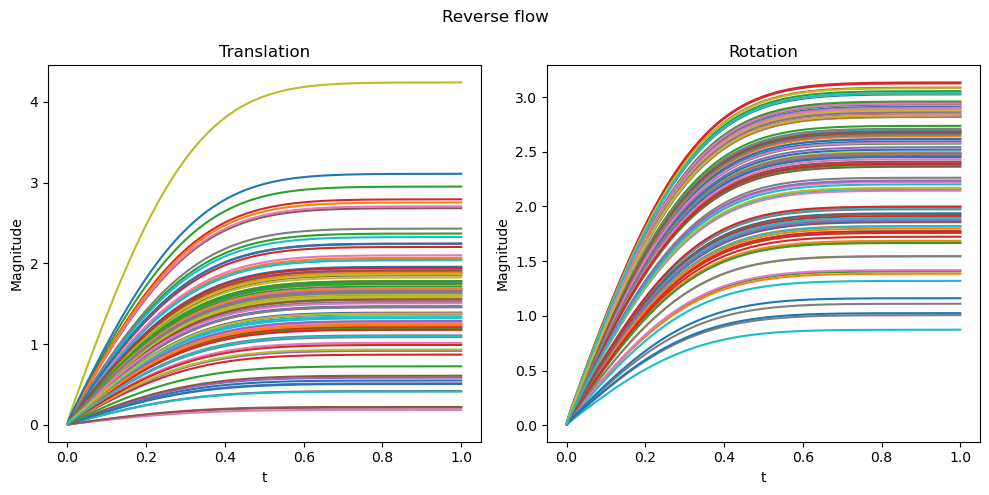

In [179]:
# Reverse flow
all_trans = [trans_nm_1]
all_rotmats = [rotmats_1]

reverse_ts = sigma_t(ts[::-1])
prev_t = reverse_ts[0]
for t in reverse_ts[1:]:
    dt = prev_t - t
    prev_trans = all_trans[-1]
    trans_vf = (trans_0 - prev_trans) / t
    trans_t = prev_trans + trans_vf * dt
    all_trans.append(trans_t)
    
    prev_rots_t = all_rotmats[-1]
    rots_t = flow_so3_utils.geodesic_t(
        dt / t, rotmats_0, prev_rots_t)
    all_rotmats.append(rots_t)
    prev_t = t

all_trans = torch.stack(all_trans)
all_rotmats = torch.stack(all_rotmats)
all_rotvecs = flow_so3_utils.rotmat_to_rotvec(all_rotmats)
all_rotmags = du.move_to_np(torch.linalg.norm(all_rotvecs, dim=-1))
all_tranmags = du.move_to_np(torch.linalg.norm(all_trans, dim=-1))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Reverse flow')
for i in range(num_samples):
    axs[0].plot(ts[::-1], all_tranmags[:, i])
    axs[0].set_title('Translation')
    axs[0].set_xlabel('t')
    axs[0].set_ylabel('Magnitude')
for i in range(num_samples):
    axs[1].plot(ts[::-1], all_rotmags[:, i])
    axs[1].set_title('Rotation')
    axs[1].set_xlabel('t')
    axs[1].set_ylabel('Magnitude')
fig.tight_layout()

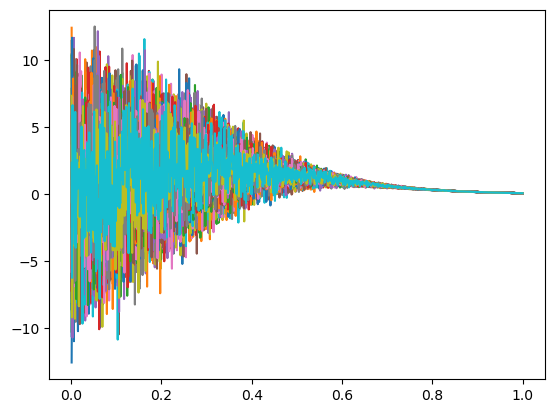

In [62]:
for i in range(num_samples):
    plt.plot(ts, vf_ts[:, i])

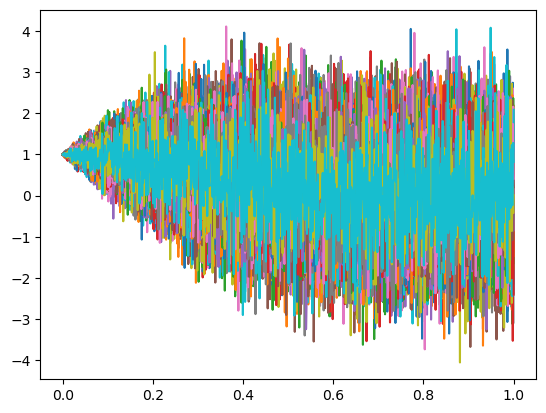

In [50]:
for i in range(num_samples):
    plt.plot(ts, x_ts[:, i])

In [48]:
def marginal_b_t(t):
    return t*beta_min + (1/2)*(t**2)*(beta_max-beta_min)

def framediff_p_t(x_0, t):
    return np.random.normal(
        loc=np.exp(-1/2*marginal_b_t(t)) * x_0,
        scale=np.sqrt(1 - np.exp(-marginal_b_t(t)))
    )

In [51]:
x_ts = []
for t in ts:
    x_t = framediff_p_t(x_0, t)
    x_ts.append(x_t)
x_ts = np.stack(x_ts)

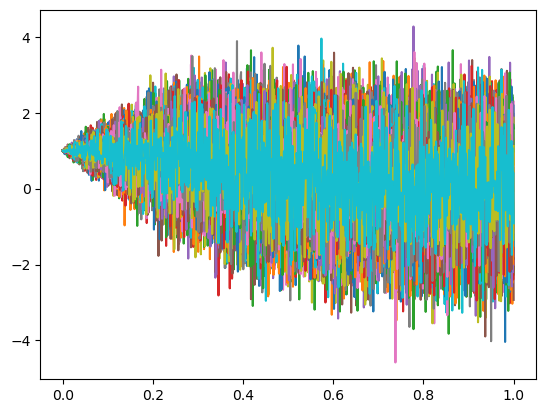

In [52]:
for i in range(num_samples):
    plt.plot(ts, x_ts[:, i])

In [ ]:
        b_t = self.marginal_b_t(t) / num_t
        z_t_1 = torch.tensor(np.random.normal(size=x_t_1.shape)).to(x_t_1.device)
        x_t = torch.sqrt(1 - b_t) * x_t_1 + torch.sqrt(b_t) * z_t_1

In [ ]:
# Run ODE
mats_1 = mats_1.float()
t_1 = ts[0]
manual_traj = [(mats_0.float(), trans_0)]
for t_2 in ts[1:]:
    d_t = t_2 - t_1
    mats_t, trans_t = manual_traj[-1]
    mats_t_1 = geodesic_t(d_t / (1 - t_1), mats_1, mats_t)
    trans_t_1 = trans_t + r3_vf_t(t_1, trans_1, trans_t) * d_t
    t_1 = t_2
    manual_traj.append((mats_t_1, trans_t_1))
trans_traj = [x[1] for x in manual_traj]
mats_traj = [x[0] for x in manual_traj]
trans_traj = torch.stack(trans_traj, dim=0).detach().numpy()
mats_traj = torch.stack(mats_traj, dim=0).detach().numpy()
vec_traj = so3_utils.rotmat_to_rotvec(torch.tensor(mats_traj)).numpy()

np.testing.assert_allclose(mats_traj[-1], mats_1, rtol=1e-2)
np.testing.assert_allclose(trans_traj[-1], trans_1, rtol=1e-2)
